In [112]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from torchvision.models.detection import keypointrcnn_resnet50_fpn, KeypointRCNN_ResNet50_FPN_Weights
# import albumentations as A # Library for augmentations
import os
import cv2
import json
import random
import argparse
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

#Very hacky fix to make matplotlib work on my pc
# import os
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized.

repo_dir = "c:/Users/James/git/3dGolfPoseDetection/"
save_dir = repo_dir + "/dev-nbs/saved-labels/"
downloaded_dir = repo_dir + "downloaded-data/"

### Hyperparameters
batch_size = 3

In [130]:
def label_img(img, club_coordinates, box_cords, line_width=4):
    grip, club = club_coordinates
    labelled = img.copy()
    cv2.circle(labelled, grip[:2], 5, (255,0,255), -1)
    cv2.circle(labelled, club[:2], 5, (255,0,255), -1)
    cv2.line(labelled, club[:2], grip[:2], (255, 0, 0), 2)
    cv2.rectangle(labelled, box_cords[:2], box_cords[2:], (0, 0, 255), line_width)
    return labelled

class GolfDataset(torch.utils.data.Dataset):
    def __init__(self, filenames, save_dir, annotate = False, resize_size = 640):
        self.save_dir = save_dir
        self.filenames = filenames # filenames of image locations
        self.resize_size = resize_size
        self.dtype = torch.float32
        self.img_transforms = transforms.ToTensor()
        self.annotate = annotate

    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        filename = self.filenames[idx]
        # img_num = int(filename.split("_")[0])
        img = cv2.imread(self.save_dir+filename)
        assert img.shape[0] == img.shape[1], f"Image is not square: {img.shape} | {filename}"

        w = img.shape[0]
        r = self.resize_size / float(w)
        img = cv2.resize(img, (self.resize_size, self.resize_size), interpolation = cv2.INTER_AREA)
        all_cords = [int(x) for x in filename.split("_")[1].split("-")]
        all_cords = [int(x*r) for x in all_cords]
        grip, club, box_cords = all_cords[:2], all_cords[2:4], all_cords[4:]
        grip.append(1.)
        club.append(1.)
        if self.annotate:
            img = label_img(img, [grip, club], box_cords)

        # During training, the model expects both the input tensors and targets (list of dictionary), containing:
        # boxes (FloatTensor[N, 4]): the ground-truth boxes in [x1, y1, x2, y2] format, with 0 <= x1 < x2 <= W and 0 <= y1 < y2 <= H.
        # labels (Int64Tensor[N]): the class label for each ground-truth box
        # keypoints (FloatTensor[N, K, 3]): the K keypoints location for each of the N instances, in the format [x, y, visibility], where visibility=0 means that the keypoint is not visible.
        

        target = {}
        target["boxes"] = torch.Tensor(box_cords).unsqueeze(dim=0).type(torch.FloatTensor)
        target["labels"] = torch.Tensor(torch.ones(1)).type(torch.int64)
        target["keypoints"] = torch.Tensor([grip, club]).unsqueeze(dim=0).type(torch.FloatTensor)
        img = Image.fromarray(img[:,:,::-1])
        img = self.img_transforms(img)      

        return img, target
    
def collate_fn(batch):
    return tuple(zip(*batch))


filenames = os.listdir(save_dir)
dataset = GolfDataset(filenames, save_dir, annotate=False, resize_size = 640)
dataloader = torch.utils.data.DataLoader(dataset, collate_fn=collate_fn, batch_size=batch_size, shuffle=False)
batch = next(iter(dataloader))

print(f"batch[0] list containing {len(batch[0])} tensors of shape {batch[0][0].shape}:")
print(f"batch[1] list containing {len(batch[1])} of the following:")
for key in batch[1][0]:
    print(f"'{key}': {batch[1][0][key].shape}, {batch[1][0][key].dtype}")

# Image.fromarray((torchvision.utils.make_grid(torch.stack(batch[0],dim=0), padding=2, normalize=True).permute(1,2,0).numpy()*255).astype(np.uint8))

batch[0] list containing 3 tensors of shape torch.Size([3, 640, 640]):
batch[1] list containing 3 of the following:
'boxes': torch.Size([1, 4]), torch.float32
'labels': torch.Size([1]), torch.int64
'keypoints': torch.Size([1, 2, 3]), torch.float32


In [131]:
model = keypointrcnn_resnet50_fpn(weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT)
model.eval()
#count parameters
print(f'Model has {sum(p.numel() for p in model.parameters()):,} parameters')

Model has 59,137,258 parameters


In [132]:
model.eval()
preds = model(batch[0])

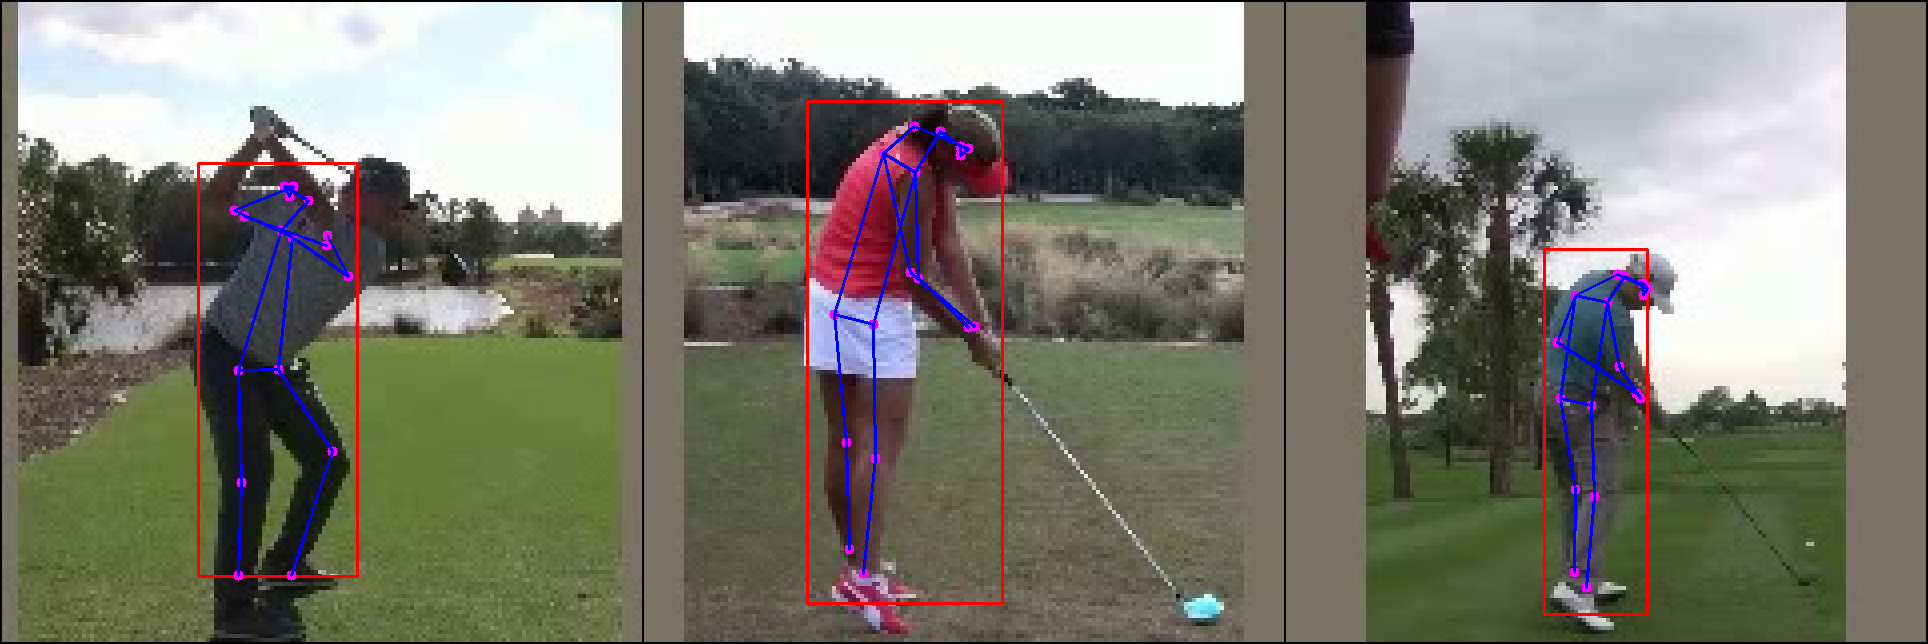

In [133]:
labelled_imgs = []
for i in range(len(preds)):
    input_img = batch[0][i]
    pred = preds[i]
    box = [int(x) for x in pred["boxes"][0].detach()]
    keypoints = [[int(x[0]), int(x[1])]  for x in pred["keypoints"][0].detach()]
    img = (input_img.permute(1,2,0).numpy()*255).astype(np.uint8)[:, :, ::-1]
    
    skeleton =  [[16,14],[14,12],[17,15],[15,13],[12,13],[6,12],[7,13],[6,7],
                [6,8],[7,9],[8,10],[9,11],[2,3],[1,2],[1,3],[2,4],[3,5],[4,6],[5,7]]

    labelled = img.copy()
    cv2.rectangle(labelled, box[:2], box[2:], (0, 0, 255), 2)
    for keypoint in keypoints:
        cv2.circle(labelled, tuple(keypoint), 5, (255,0,255), -1)

    for pair in skeleton:
        cv2.line(labelled, keypoints[pair[0]-1], keypoints[pair[1]-1], (255, 0, 0), 2)

    labelled_imgs.append(torch.Tensor(labelled[:, :, ::-1]/255.))
    # display( Image.fromarray(labelled[:, :, ::-1]))

Image.fromarray((torchvision.utils.make_grid(torch.stack(labelled_imgs,dim=0).permute(0,3,1,2), padding=2, normalize=True).permute(1,2,0).numpy()*255).astype(np.uint8))

In [135]:
out = nn.ConvTranspose2d(512, 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
model.roi_heads.keypoint_predictor.kps_score_lowres = out

batch = next(iter(dataloader))
model.train()
metrics = model(*batch)
metrics

{'loss_classifier': tensor(0.1746, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.0768, grad_fn=<DivBackward0>),
 'loss_keypoint': tensor(10.6973, grad_fn=<NllLossBackward0>),
 'loss_objectness': tensor(0.0764, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0030, grad_fn=<DivBackward0>)}

In [138]:
model.eval()
preds = model(batch[0])
preds

[{'boxes': tensor([[196.7647, 161.6837, 355.8739, 574.6700],
          [458.2339, 256.9807, 464.1445, 272.8716],
          [455.7396, 254.4996, 464.2141, 277.8954],
          [445.8767, 248.3218, 458.3318, 281.7727],
          [307.4313, 191.0459, 333.5754, 257.4498],
          [111.1199,  98.3755, 391.9510, 627.4518]], grad_fn=<StackBackward0>),
  'labels': tensor([1, 1, 1, 1, 1, 1]),
  'scores': tensor([0.2716, 0.0919, 0.0822, 0.0718, 0.0710, 0.0633],
         grad_fn=<IndexBackward0>),
  'keypoints': tensor([[[347.4787, 199.6274,   1.0000],
           [273.1211, 287.4968,   1.0000]],
  
          [[463.7751, 272.4743,   1.0000],
           [460.0810, 262.9398,   1.0000]],
  
          [[460.7472, 277.5055,   1.0000],
           [457.6656, 256.4493,   1.0000]],
  
          [[447.8228, 280.5781,   1.0000],
           [456.3857, 255.8881,   1.0000]],
  
          [[332.3870, 201.7180,   1.0000],
           [322.8801, 196.9749,   1.0000]],
  
          [[377.1914, 185.8889,   1.0000],


[196, 161, 355, 574] [[347, 199], [273, 287]]
[163, 99, 358, 601] [[208, 310], [277, 215]]
[258, 247, 361, 612] [[356, 307], [323, 332]]


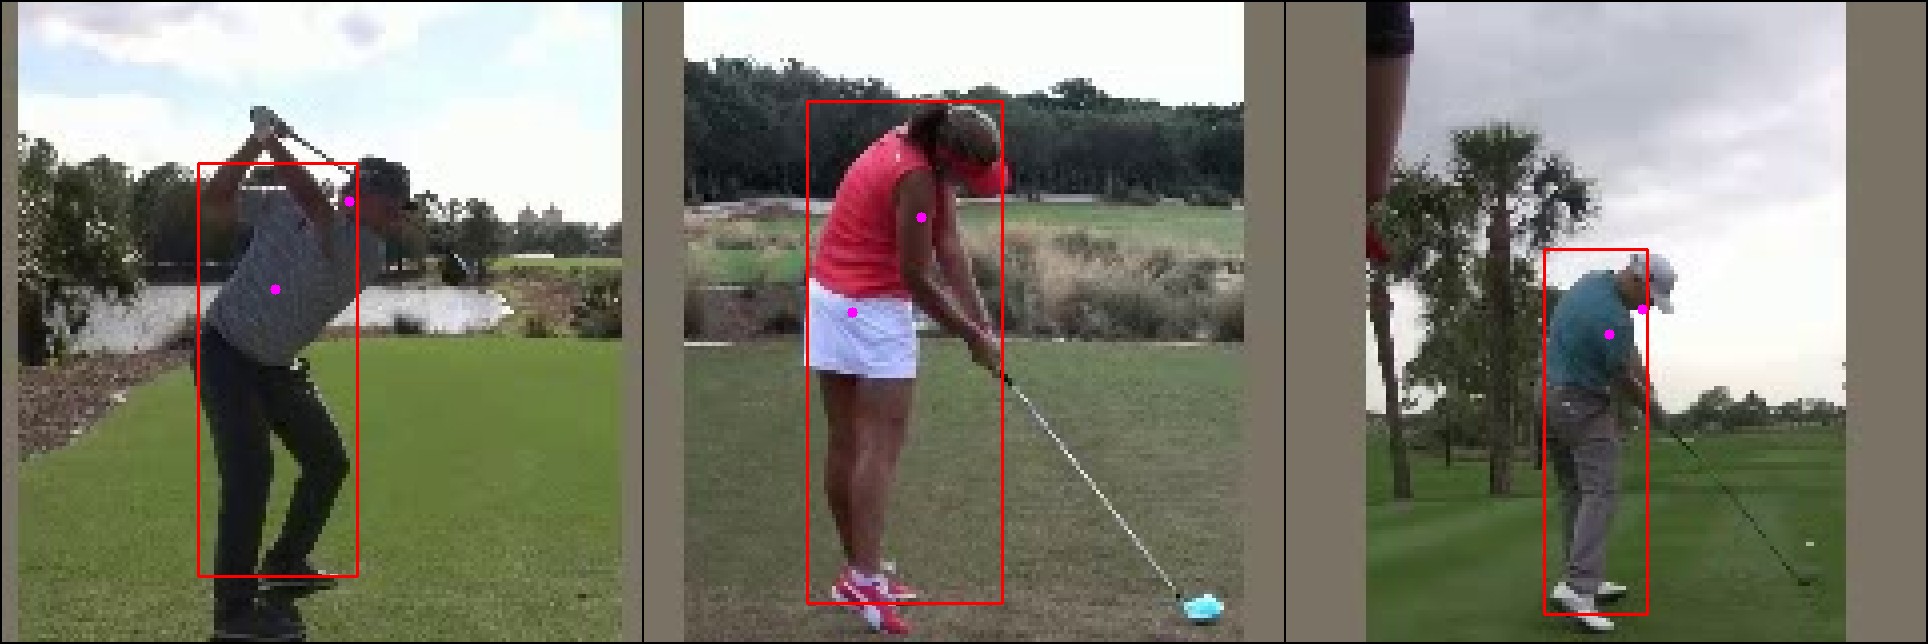

In [144]:
labelled_imgs = []
for i in range(len(preds)):
    input_img = batch[0][i]
    pred = preds[i]
    box = [int(x) for x in pred["boxes"][0].detach()]
    keypoints = [[int(x[0]), int(x[1])]  for x in pred["keypoints"][0].detach()]
    print(box, keypoints)

    img = (input_img.permute(1,2,0).numpy()*255).astype(np.uint8)[:, :, ::-1]
    labelled = img.copy()
    cv2.rectangle(labelled, box[:2], box[2:], (0, 0, 255), 2)
    cv2.circle(labelled, keypoints[0], 5, (255,0,255), -1) # handle
    cv2.circle(labelled, keypoints[1], 5, (255,0,255), -1) # club head
    labelled_imgs.append(torch.Tensor(labelled[:, :, ::-1]/255.))
    # display( Image.fromarray(labelled[:, :, ::-1]))

Image.fromarray((torchvision.utils.make_grid(torch.stack(labelled_imgs,dim=0).permute(0,3,1,2), padding=2, normalize=True).permute(1,2,0).numpy()*255).astype(np.uint8))